In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [30]:
rsock = pd.read_csv("../NewRS/ReqRes/data.csv")
rsock.head()

,Time [ms],CPU usage [%],GC activity [%],Size [B],Used [B],Live,Daemon
0,"9:38:30.503 am, 06-Jul-2023",0.1,0.0,"142,606,368","51,899,712",37,18
1,"9:38:31.504 am, 06-Jul-2023",0.0,0.0,"142,606,368","51,899,712",37,18
2,"9:38:32.504 am, 06-Jul-2023",0.1,0.0,"142,606,368","51,899,712",37,18
3,"9:38:33.507 am, 06-Jul-2023",10.9,0.0,"142,606,368","68,676,928",63,44
4,"9:38:34.510 am, 06-Jul-2023",51.0,0.0,"142,606,368","31,759,640",63,44


In [269]:
def parse_to_standard(path: str):
    common_df = pd.read_csv(path)
    cpu_df = pd.DataFrame(common_df["CPU usage [%]"])
    cpu_df.columns = ["CPU Usage"]
    cpu_df["Time"] = cpu_df.index
    
    mem_df = pd.DataFrame(common_df["Used [B]"].apply(lambda x: int(x.replace(",", ""))/1e6))
    mem_df.columns = ["Used"]
    mem_df["Time"] = mem_df.index
    
    thread_df = pd.DataFrame(common_df["Live"])
    thread_df.columns = ["Live threads"]
    thread_df["Time"] = thread_df.index

    return (cpu_df, mem_df, thread_df)


In [270]:

rsocket_req_res_cpu, rsocket_req_res_mem, rsocket_req_res_thread = parse_to_standard("../NewRs/ReqRes/data.csv")
rsocket_req_res_throughput = pd.read_csv("../NewRs/ReqRes/throughput.csv")
rsocket_req_stream_cpu, rsocket_req_stream_mem, rsocket_req_stream_thread = parse_to_standard("../NewRs/ReqStream/data.csv")
rsocket_req_stream_throughput = pd.read_csv("../NewRs/ReqStream/throughput.csv")
rsocket_stream_res_cpu, rsocket_stream_res_mem, rsocket_stream_res_thread = parse_to_standard("../NewRs/StreamRes/data.csv")
rsocket_stream_res_throughput = pd.read_csv("../NewRs/StreamRes/throughput.csv")
rsocket_channel_cpu, rsocket_channel_mem, rsocket_channel_thread = parse_to_standard("../NewRs/Channel/data.csv")
rsocket_channel_throughput = pd.read_csv("../NewRs/Channel/throughput.csv")

grpc_req_res_cpu, grpc_req_res_mem, grpc_req_res_thread = parse_to_standard("../NewGrpc/ReqRes/data.csv")
grpc_req_res_throughput = pd.read_csv("../NewGrpc/ReqRes/throughput.csv")
grpc_req_stream_cpu, grpc_req_stream_mem, grpc_req_stream_thread = parse_to_standard("../NewGrpc/ReqStream/data.csv")
grpc_req_stream_throughput = pd.read_csv("../NewGrpc/ReqStream/throughput.csv")
grpc_stream_res_cpu, grpc_stream_res_mem, grpc_stream_res_thread = parse_to_standard("../NewGrpc/StreamRes/data.csv")
grpc_stream_res_throughput = pd.read_csv("../NewGrpc/StreamRes/throughput.csv")
grpc_channel_cpu, grpc_channel_mem, grpc_channel_thread = parse_to_standard("../NewGrpc/Channel/data.csv")
grpc_channel_throughput = pd.read_csv("../NewGrpc/Channel/throughput.csv")

In [271]:
def scale_values(values: list, new_min: float, new_max: float):
    values = np.array(values)

    min_val = np.min(values)
    max_val = np.max(values)

    factor1 = new_min / min_val
    factor2 = new_max / max_val

    return (factor1 + factor2) / 2

In [272]:
def process_time_values(df: pd.DataFrame, time_column: str = "Time"):
    time_values = df[time_column] - df[time_column].min()
    time_values = time_values * 1000000
    time_values = time_values.apply(lambda x: int(x))
    return time_values

In [273]:
def plot_through_put_line(
    time_values,
    rsocket_throughput: pd.DataFrame = None,
    grpc_throughput: pd.DataFrame = None,
    y_max=None,
    y_min=None,
    labels=None,
):
    font = {'family': 'Proxima Nova', 'size': 12}
    plt.rc('font', **font)
    x_max = max(time_values)
    x_min = min(time_values)

    split = np.linspace(x_min, x_max, 5)
    ranges = list(zip(split[0:-1], split[1:]))
    x_pos_throughput = [range[0] + (range[1] - range[0]) / 2 for range in ranges]

    rsocket_throughput_values = rsocket_throughput["Score"]
    grpc_throughput_values = grpc_throughput["Score"]

    factor = 1

    if y_max is not None and x_max is not None:
        factor = scale_values(rsocket_throughput_values, 1.2 * y_min, 0.7 * y_max)

    plt.plot(
        x_pos_throughput,
        list(map(lambda x: factor * x, rsocket_throughput_values)),
        color=[219/255,50/255,143/255],
        linestyle="--",
        marker = "o",
        label="RSocket Troughput",
    )
    plt.plot(
        x_pos_throughput,
        list(map(lambda x: factor * x, grpc_throughput_values)),
        color=[100/255,189/255,189/255],
        linestyle="--",
        marker='o',
        label="gRPC Throughput",
    )

    if labels == None:
        plt.xticks(x_pos_throughput)
    else:
        plt.xticks(x_pos_throughput, labels)

In [334]:
def draw_throughput_chart(
    rsocket_df: pd.DataFrame, grpc_df: pd.DataFrame, thread_stats, title: str = "Throughput"
):
    font = {'family': 'Proxima Nova', 'size': 12}
    plt.rc('font', **font)
    rsocket_throughput_values = rsocket_df["Score"]
    grpc_throughput_values = grpc_df["Score"]

    width = 0.25
    plt.barh(
        [i - width / 2 for i in range(len(rsocket_throughput_values))],
        rsocket_throughput_values,
        color=[219/255,50/255,143/255],
        label="RSocket",
        height=width,
    )
    plt.barh(
        [i + width / 2 for i in range(len(grpc_throughput_values))],
        grpc_throughput_values,
        color=[100/255,189/255,189/255],
        label="gRPC",
        height=width,
    )

    plt.yticks([i for i in range(len(rsocket_throughput_values))], thread_stats)
    plt.ylabel("Num of Threads")
    plt.xlabel("Throughput")
    plt.legend()
    plt.title(title)
    plt.show()

In [335]:
def draw_cpu_chart(
    rsocket_df: pd.DataFrame,
    grpc_df: pd.DataFrame,
    rsocket_throughput: pd.DataFrame = None,
    grpc_throughput: pd.DataFrame = None,
    throughput_labels=None,
    title="CPU Usage chart"
):
    font = {'family': 'Proxima Nova', 'size': 12}
    plt.rc('font', **font)
    rsocket_time_values = process_time_values(rsocket_df)

    rsocket_cpu_coordinates_x = list(rsocket_time_values)
    rsocket_cpu_coordinates_y = list(rsocket_df["CPU Usage"])
    rsocket_cpu_coordinates_y_s = np.convolve(
        rsocket_cpu_coordinates_y, np.ones(3) / 3, mode="same"
    )

    plt.plot(
        rsocket_cpu_coordinates_x,
        rsocket_cpu_coordinates_y,
        color=[219/255,50/255,143/255],
        label="RSocket",
        alpha=0.8,
    )

    grpc_time_values = process_time_values(grpc_df)

    grpc_cpu_coordinates_x = list(grpc_time_values)
    grpc_cpu_coordinates_y = list(grpc_df["CPU Usage"])
    grpc_cpu_coordinates_y_s = np.convolve(
        grpc_cpu_coordinates_y, np.ones(3) / 3, mode="same"
    )

    plt.plot(
        grpc_cpu_coordinates_x,
        grpc_cpu_coordinates_y,
        color=[100/255,189/255,189/255],
        label="gRPC",
        alpha=0.8,
    )

    if grpc_throughput is not None and rsocket_throughput is not None:
        plot_through_put_line(
            grpc_time_values,
            rsocket_throughput,
            grpc_throughput,
            max(grpc_cpu_coordinates_y),
            min(grpc_cpu_coordinates_y),
            labels=throughput_labels,
        )

    plt.title(title)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    plt.xlabel("Time")
    plt.ylabel("CPU Usage")
    plt.show()

In [336]:
def draw_thread_chart(
    rsocket_df: pd.DataFrame,
    grpc_df: pd.DataFrame,
    rsocket_throughput: pd.DataFrame = None,
    grpc_throughput: pd.DataFrame = None,
    throughput_labels=None,
    title = "Live Thread Chart"
):
    font = {'family': 'Proxima Nova', 'size': 12}
    plt.rc('font', **font)
    rsocket_time_values = process_time_values(rsocket_df)

    rsocket_thread_coordinates_x = list(rsocket_time_values)
    rsocket_thread_coordinates_y = list(rsocket_df["Live threads"])
    rsocket_thread_coordinates_y_s = np.convolve(
        rsocket_thread_coordinates_y, np.ones(3) / 3, mode="same"
    )

    grpc_time_values = process_time_values(grpc_df)

    grpc_thread_coordinates_x = list(grpc_time_values)
    grpc_thread_coordinates_y = list(grpc_df["Live threads"])
    grpc_thread_coordinates_y_s = np.convolve(
        grpc_thread_coordinates_y, np.ones(3) / 3, mode="same"
    )

    plt.plot(
        grpc_thread_coordinates_x,
        grpc_thread_coordinates_y,
        color=[100/255,189/255,189/255],
        label="gRPC",
        alpha=0.8,
    )
    plt.plot(
        rsocket_thread_coordinates_x,
        rsocket_thread_coordinates_y,
        color=[219/255,50/255,143/255],
        label="RSocket",
        alpha=0.8,
    )

    if grpc_throughput is not None and rsocket_throughput is not None:
        plot_through_put_line(
            grpc_time_values,
            rsocket_throughput,
            grpc_throughput,
            max(grpc_thread_coordinates_y),
            min(grpc_thread_coordinates_y),
            labels=throughput_labels,
        )

    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    plt.xlabel("Time")
    plt.ylabel("Live threads")
    plt.title(title)
    plt.show()

In [337]:
def draw_mem_chart(
    rsocket_df: pd.DataFrame,
    grpc_df: pd.DataFrame,
    window: int = 9,
    rsocket_throughput: pd.DataFrame = None,
    grpc_throughput: pd.DataFrame = None,
    throughput_labels=None,
    title="Memory Usage Chart"
):
    font = {'family': 'Proxima Nova', 'size': 12}
    plt.rc('font', **font)
    rsocket_time_values = process_time_values(rsocket_df)

    rsocket_mem_coordinates_x = list(rsocket_time_values)
    rsocket_mem_coordinates_y = list(rsocket_df["Used"])
    rsocket_mem_coordinates_y_s = np.convolve(
        rsocket_mem_coordinates_y, np.ones(window) / window, mode="same"
    )

    grpc_time_values = process_time_values(grpc_df)

    grpc_mem_coordinates_x = list(grpc_time_values)
    grpc_mem_coordinates_y = list(grpc_df["Used"])
    grpc_mem_coordinates_y_s = np.convolve(
        grpc_mem_coordinates_y, np.ones(window) / window, mode="same"
    )

    plt.plot(
        grpc_mem_coordinates_x,
        grpc_mem_coordinates_y_s,
        color=[100/255,189/255,189/255],
        label="gRPC",
        alpha=0.8,
    )
    plt.plot(
        rsocket_mem_coordinates_x,
        rsocket_mem_coordinates_y_s,
        color=[219/255,50/255,143/255],
        label="RSocket",
        alpha=0.8,
    )

    if grpc_throughput is not None and rsocket_throughput is not None:
        plot_through_put_line(
            grpc_time_values,
            rsocket_throughput,
            grpc_throughput,
            max(grpc_mem_coordinates_y),
            min(grpc_mem_coordinates_y),
            labels=throughput_labels,
        )

    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    plt.xlabel("Time")
    plt.ylabel("Used Memory")
    plt.title(title)
    plt.show()

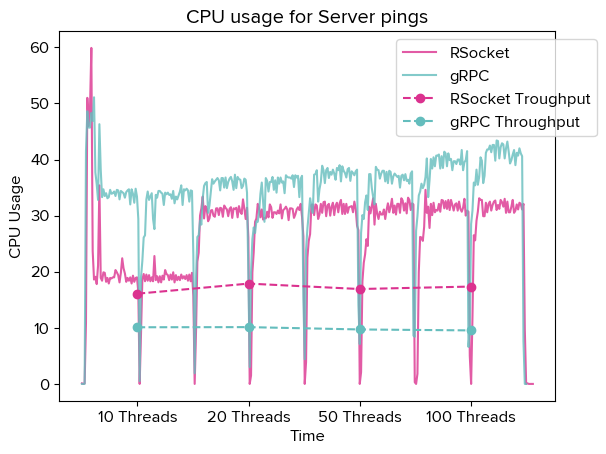

In [338]:
draw_cpu_chart(
    rsocket_req_res_cpu,
    grpc_req_res_cpu,
    grpc_throughput=grpc_req_res_throughput,
    rsocket_throughput=rsocket_req_res_throughput,
    throughput_labels=[
        "10 Threads",
        "20 Threads",
        "50 Threads",
        "100 Threads",
    ],
    title = "CPU usage for Server pings"
)

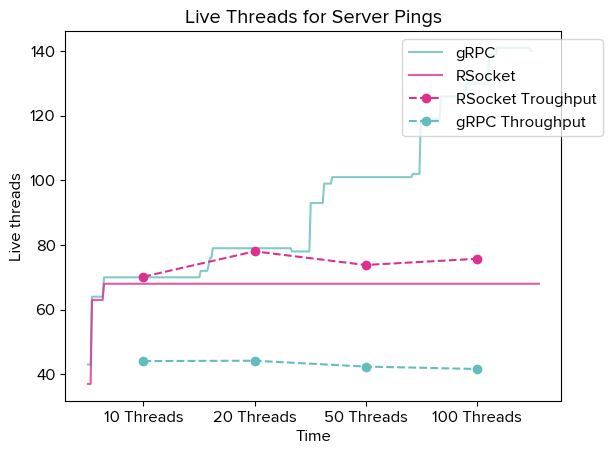

In [339]:
draw_thread_chart(
    rsocket_req_res_thread,
    grpc_req_res_thread,
    grpc_throughput=grpc_req_res_throughput,
    rsocket_throughput=rsocket_req_res_throughput,
    throughput_labels=[
        "10 Threads",
        "20 Threads",
        "50 Threads",
        "100 Threads",
    ],
    title="Live Threads for Server Pings"
)

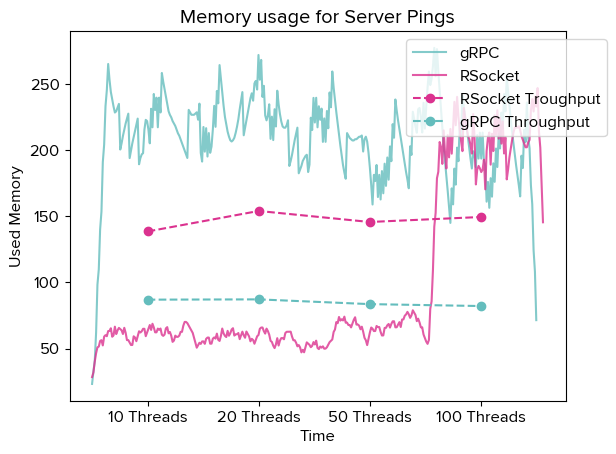

In [340]:
draw_mem_chart(
    rsocket_req_res_mem,
    grpc_req_res_mem,
    grpc_throughput=grpc_req_res_throughput,
    rsocket_throughput=rsocket_req_res_throughput,
    throughput_labels=[
        "10 Threads",
        "20 Threads",
        "50 Threads",
        "100 Threads",
    ],
    title="Memory usage for Server Pings"
)

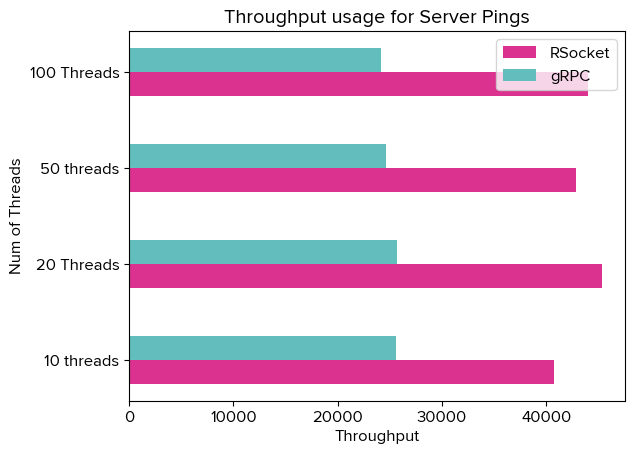

In [341]:
draw_throughput_chart(
    rsocket_req_res_throughput,
    grpc_req_res_throughput,
    [
        "10 threads",
        "20 Threads",
        "50 threads",
        "100 Threads",
    ],
    title="Throughput usage for Server Pings"
)

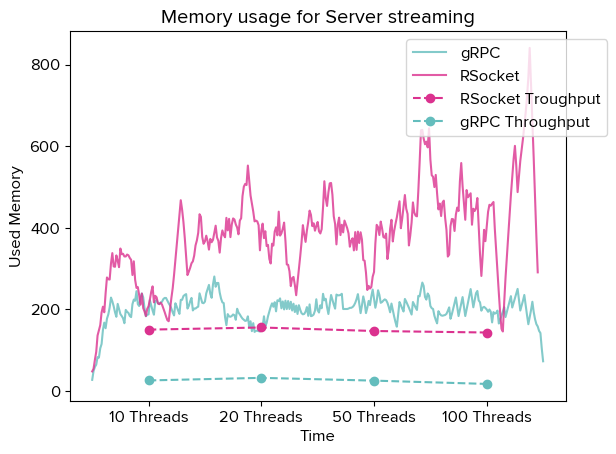

In [321]:
draw_mem_chart(
    rsocket_req_stream_mem,
    grpc_req_stream_mem,
    grpc_throughput=grpc_req_stream_throughput,
    rsocket_throughput=rsocket_req_stream_throughput,
    throughput_labels=["10 Threads", "20 Threads", "50 Threads", "100 Threads"],
    title="Memory usage for Server streaming"
)

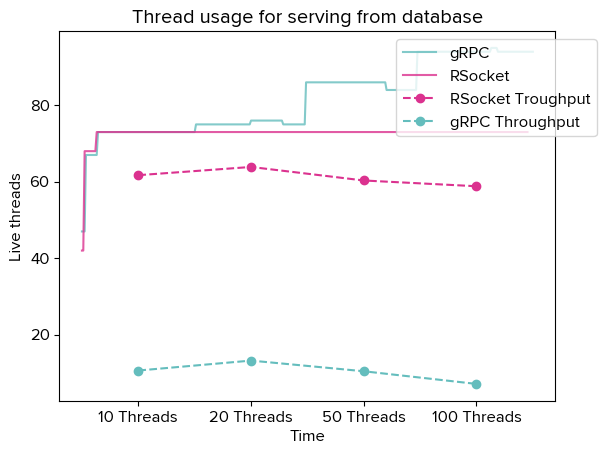

In [322]:
draw_thread_chart(
    rsocket_req_stream_thread,
    grpc_req_stream_thread,
    grpc_throughput=grpc_req_stream_throughput,
    rsocket_throughput=rsocket_req_stream_throughput,
    throughput_labels=["10 Threads", "20 Threads", "50 Threads", "100 Threads"],
    title="Thread usage for serving from database"
)

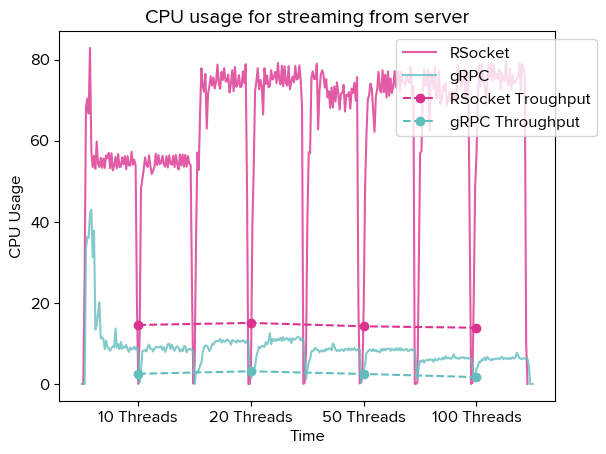

In [323]:
draw_cpu_chart(
    rsocket_req_stream_cpu,
    grpc_req_stream_cpu,
    grpc_throughput=grpc_req_stream_throughput,
    rsocket_throughput=rsocket_req_stream_throughput,
    throughput_labels=["10 Threads", "20 Threads", "50 Threads", "100 Threads"],
    title="CPU usage for streaming from server"

)

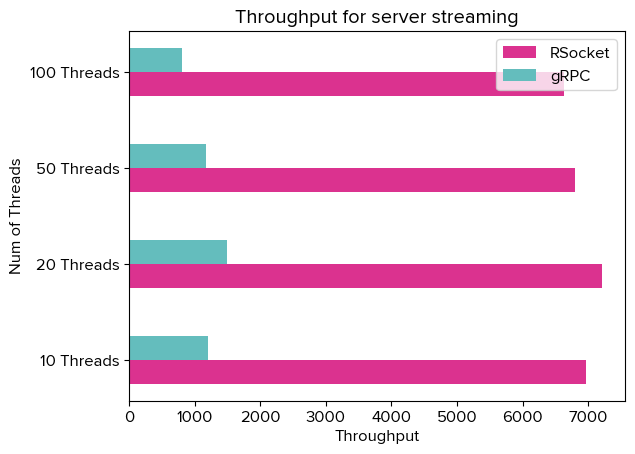

In [342]:
draw_throughput_chart(rsocket_req_stream_throughput, grpc_req_stream_throughput, ["10 Threads", "20 Threads", "50 Threads", "100 Threads"],title="Throughput for server streaming")

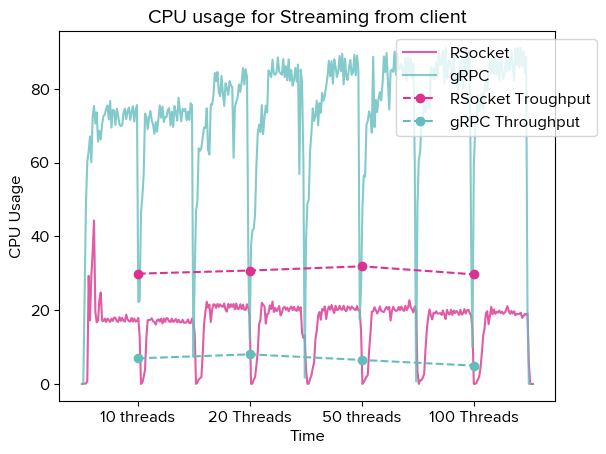

In [325]:
draw_cpu_chart(
    rsocket_stream_res_cpu,
    grpc_stream_res_cpu,
    rsocket_stream_res_throughput,
    grpc_stream_res_throughput,
    [
        "10 threads",
        "20 Threads",
        "50 threads",
        "100 Threads",
    ],
    title="CPU usage for Streaming from client"
)

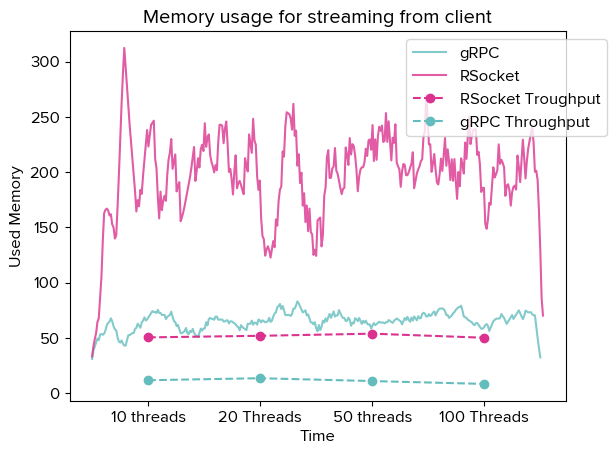

In [326]:
draw_mem_chart(
    rsocket_stream_res_mem,
    grpc_stream_res_mem,
    rsocket_throughput= rsocket_stream_res_throughput,
    grpc_throughput= grpc_stream_res_throughput,
    throughput_labels=[
        "10 threads",
        "20 Threads",
        "50 threads",
        "100 Threads",
    ],
    title="Memory usage for streaming from client"
)

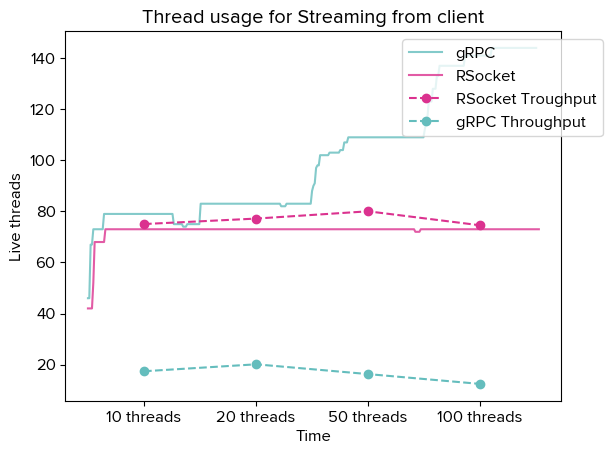

In [327]:
draw_thread_chart(
    rsocket_stream_res_thread,
    grpc_stream_res_thread,
    rsocket_stream_res_throughput,
    grpc_stream_res_throughput,
    [
        "10 threads",
        "20 threads",
        "50 threads",
        "100 threads",
    ],
    title="Thread usage for Streaming from client"
)

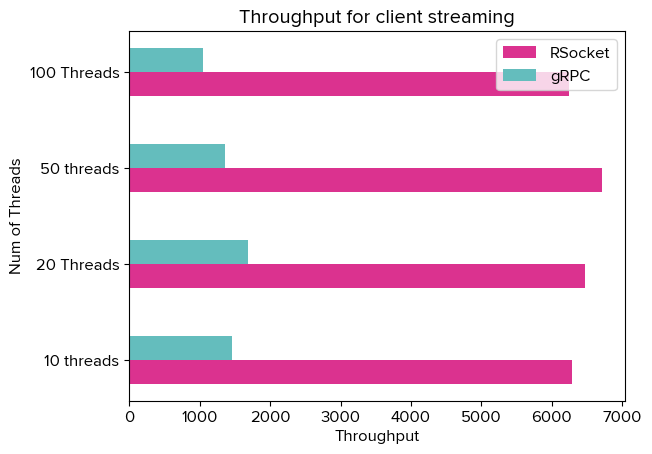

In [344]:
draw_throughput_chart(
    rsocket_stream_res_throughput,
    grpc_stream_res_throughput,
    [
        "10 threads",
        "20 Threads",
        "50 threads",
        "100 Threads",
    ],
    title="Throughput for client streaming"
)

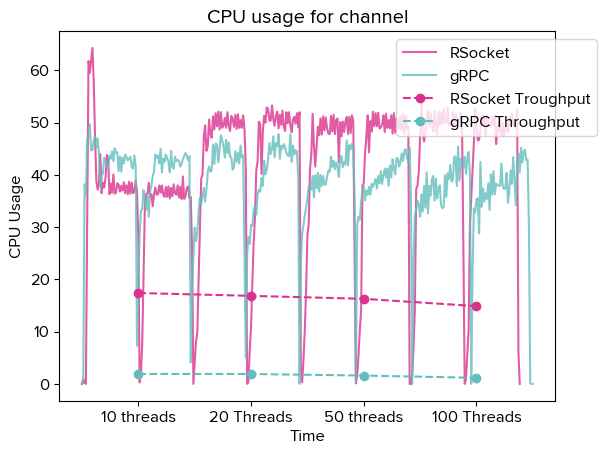

In [329]:
draw_cpu_chart(
    rsocket_channel_cpu,
    grpc_channel_cpu,
    rsocket_channel_throughput,
    grpc_channel_throughput,
    [
        "10 threads",
        "20 Threads",
        "50 threads",
        "100 Threads",
    ],
    title="CPU usage for channel"
)

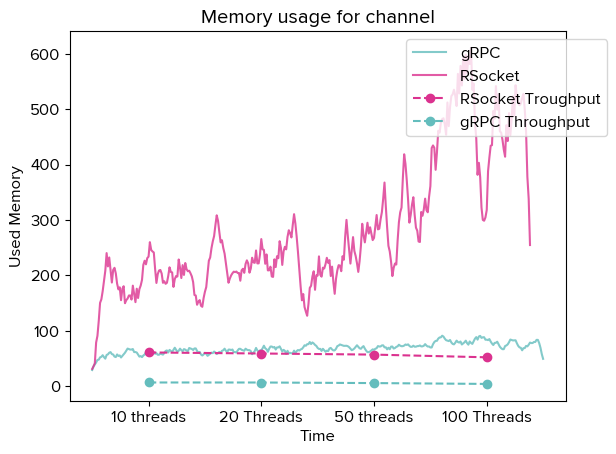

In [330]:
draw_mem_chart(
    rsocket_channel_mem,
    grpc_channel_mem,
    rsocket_throughput= rsocket_channel_throughput,
    grpc_throughput= grpc_channel_throughput,
    throughput_labels=[
        "10 threads",
        "20 Threads",
        "50 threads",
        "100 Threads",
    ],
    title="Memory usage for channel"
)

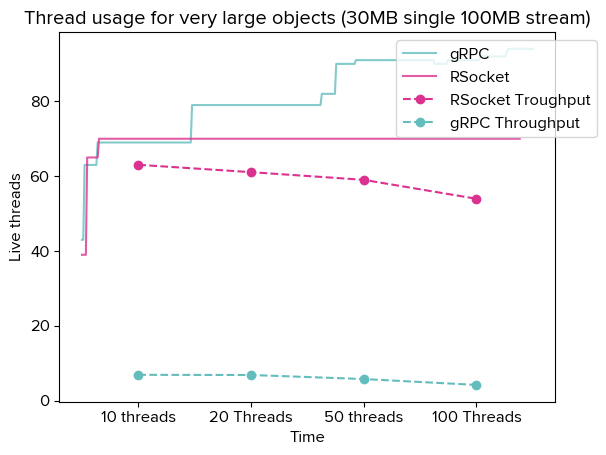

In [331]:
draw_thread_chart(
    rsocket_channel_thread,
    grpc_channel_thread,
    rsocket_channel_throughput,
    grpc_channel_throughput,
    [
        "10 threads",
        "20 Threads",
        "50 threads",
        "100 Threads",
    ],
    title="Thread usage for very large objects (30MB single 100MB stream)"
)

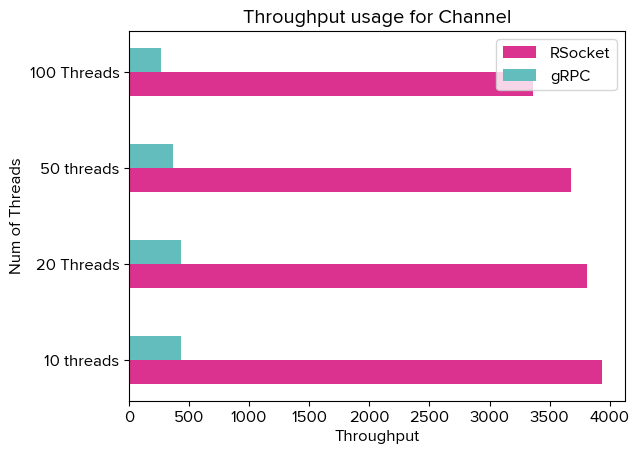

In [343]:
draw_throughput_chart(
    rsocket_channel_throughput,
    grpc_channel_throughput,
    [
        "10 threads",
        "20 Threads",
        "50 threads",
        "100 Threads",
    ],
    title="Throughput for Channel"
)